# Классификация и градиентные спуски

В этой тетрадке мы попробуем немного посмотреть на то, как работают разные градиентные спуски. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings         # чтобы никто не мешал бесчинствам с кодом
warnings.filterwarnings("ignore") # обработка всевозсожных warnings путем их игнорирования

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    ROOT = Path("/content/drive/My Drive/data/") # your path
    
    assert ROOT.is_dir(), "Have you forgotten to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.append(str(ROOT))
else:
    ROOT = Path("data/")

# 1. Выборка

Делать всё это мы будем на животных. Ежегодно около 7.6 миллионов бедных животных в США оказываются в приютах. Часть из них находит себе новую семью, часть возвращается к старому (бывает, что питомец потерялся и его нашли на улице), а часть погибает. Ужегодно усыпляется около 2.7 млн. собак и кошек.  

Используя датасет с входной информацией (цвет, пол, возраст и т.п.) из одного из приютов, мы попытаемся спрогнозировать что произойдёт с новыми животными, которые попадут в этот приют. Данные, используемые в тетрадке уже были предварительно обработаны и приведены в удобную для построения моделей форму. 

In [3]:
X = pd.read_csv(f'{ROOT}/X_cat.csv', sep = '\t', index_col=0)
target = pd.read_csv(f'{ROOT}/y_cat.csv', sep = '\t', index_col=0,  names=['status'])

print(X.shape)
X.head()

(26729, 37)


,IsDog,Age,HasName,NameLength,NameFreq,MixColor,ColorFreqAsIs,ColorFreqBase,TabbyColor,MixBreed,...,SexStatus_Flawed,SexStatus_Intact,SexStatus_Unknown,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,1,365.0,1,7,0.000157,1,0.032919,0.463624,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,365.0,1,5,0.000655,0,0.008092,0.015005,1,1,...,1,0,0,0,0,0,0,0,0,1
2,1,730.0,1,6,0.000052,1,0.026293,0.357521,0,1,...,1,0,0,0,0,0,0,0,1,0
3,0,21.0,0,7,0.285871,0,0.000471,0.058418,0,1,...,0,1,0,0,0,0,0,1,0,0
4,1,730.0,0,7,0.285871,0,0.023831,0.075353,0,0,...,1,0,0,0,0,0,0,1,0,0


В датасете находится около 27 тысяч наблюдений и 39 регрессоров. Посмотрим на то как выглядит распределение того, что произошло со зверятами по особям.

In [4]:
target.status.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: status, dtype: int64

Видим, что классы несбалансированы. Попробуем оставит четыре класса и объединить класс умерших животных с классом животных, которых усыпили. 

In [5]:
target = target.values
target[target == 'Died'] = 'Euthanasia'

Закодируем классы.

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(target)
y

array([2, 1, 0, ..., 0, 3, 3])

In [7]:
len(y)

26729

In [8]:
X.shape

(26729, 37)

Разобьём выборку на тренировочную и тестовую. 

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(21383, 37)
(5346, 37)


In [10]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

# 2. Архитектурка

In [11]:
import torch
import torch.nn as nn            # содержит функции для реалзации архитектуры нейронных сетей
import torch.nn.functional as F  # содержит различные функции активации и не только
import torch.optim as optim
import torch.utils.data as data_utils

Функция для рисования графиков

In [12]:
def plot(histories):
    plt.figure(figsize=(16,10))
    
    for name, val_loss in histories:
        plt.plot(val_loss, label=name)

    plt.legend()

 Соберем архитектуру модели

In [13]:
INPUT_SIZE = 37
HIDDEN_SIZE = 25
OUTPUT_SIZE = 4
BATCH_SIZE = 1000
EPOCHS = 100
LEARNING_RATE = 0.001

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=INPUT_SIZE, out_features=HIDDEN_SIZE)
        self.fc2 = nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE)
        self.out = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.out(x)
        
        return x

model = MyModel()

Напишем функцию, которая будет тренировать нейронную сеть. Функция имеет 2 логические части: первая - тренировочная, вторая - валидационная, другими словами, та, на которой вычисляется ошибка и сравнивается с ошибкой на тренировочных данных

In [14]:
def run_train(model, optimizer, criterion, scheduler=None):
    train_loss_values = []
    train_accuracy_values = []
    valid_loss_values = []
    valid_accuracy = []
    lr_history = []

    model.train()
    for epoch in range(EPOCHS):
        running_loss = []
        running_acc = []
        for features, label in train_loader:
            # Reset gradients
            optimizer.zero_grad()
            
            # run model on the chosen batch
            output = model(features)

            # Calculate error and backpropagate
            loss = criterion(output, label)
            loss.backward()

            # manual accuracy calculation; no torch lightning
            acc = (output.argmax(dim=1)==label).sum() / len(label)

            # Update weights with gradients
            optimizer.step()

            running_loss.append(loss.item())
            running_acc.append(acc)


        train_loss_values.append(np.mean(running_loss))
        train_accuracy_values.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print('EPOCH %d,  train_loss: %f, valid_accuracy: %f' % (epoch, train_loss_values[-1], train_accuracy_values[-1]))


        model.eval()
        # Run validation
        running_loss = []
        running_acc = []
        with torch.no_grad(): # in validation loop we do not need gradients calculation; so switch it off
            for features, label in test_loader:
                output = model(features)
                
                # Calculate error ana accuracy
                loss = criterion(output, label)
                acc = (output.argmax(dim=1)==label).sum() / len(label)

                running_loss.append(loss.item())
                running_acc.append(acc)

            valid_loss_values.append(np.mean(running_loss))
            valid_accuracy.append(np.mean(running_acc))
            if epoch % 20 == 0:
                print('EPOCH %d, valid_loss: %f, valid_accuracy: %f' % (epoch, valid_loss_values[-1], valid_accuracy[-1]))

        if scheduler is not None:
            # Decay Learning Rate
            scheduler.step()
            lr_history.append(scheduler.get_last_lr())

    if scheduler is not None:
        return train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy, lr_history
        
    return train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy

Создадим PyTorch `Dataloader`. Объект DataLoader принимает на вход датасет и ряд параметров, задающих процедуру формирования батча данных.

Основным входным параметром `Dataloader` является объект PyTorch `Dataset`. Он нужен для доступа к элементы данных по конкретному индексу. 

На первый взгляд такая конструкция может показаться странной и излишней. Однако к ней просто нужно привыкнуть и со временем станет понятно насколько она удобна и лаконична. В силу своей гибкости она позволяет формировать размер и структуру батча по желанию, а также собирать батч из заранее выбранных элементов данных. Такая кастомная сборка батча может пригодиться, например, при работе с последовательными данными, такими как предложения в тексте, имеющими разную длину. 

In [15]:
def create_data_loader(X_train, y_train, X_test, y_test):
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train))
    train_loader = data_utils.DataLoader(dataset=train_tensor,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)
    return train_loader, test_loader

train_loader, test_loader = create_data_loader(X_train, y_train, X_test, y_test)

# 3. Оптимизация 

### SGD 

In [16]:
# Первая простенькая моделька 
model1 = MyModel()

# инициализируем SGD optimizer
sgd = optim.SGD(model1.parameters(), lr=LEARNING_RATE)

# инициализируем Loss function (функцию потерь)
criterion = nn.CrossEntropyLoss()

# запускаем процесс обучения
train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy = run_train(model1, optimizer=sgd, criterion=criterion)

EPOCH 0,  train_loss: 1.377412, valid_accuracy: 0.242631
EPOCH 0, valid_loss: 1.377500, valid_accuracy: 0.243979
EPOCH 20,  train_loss: 1.332561, valid_accuracy: 0.351012
EPOCH 20, valid_loss: 1.332836, valid_accuracy: 0.349228
EPOCH 40,  train_loss: 1.298701, valid_accuracy: 0.367486
EPOCH 40, valid_loss: 1.299010, valid_accuracy: 0.366249
EPOCH 60,  train_loss: 1.271999, valid_accuracy: 0.426550
EPOCH 60, valid_loss: 1.272354, valid_accuracy: 0.427716
EPOCH 80,  train_loss: 1.250082, valid_accuracy: 0.497890
EPOCH 80, valid_loss: 1.250532, valid_accuracy: 0.499205


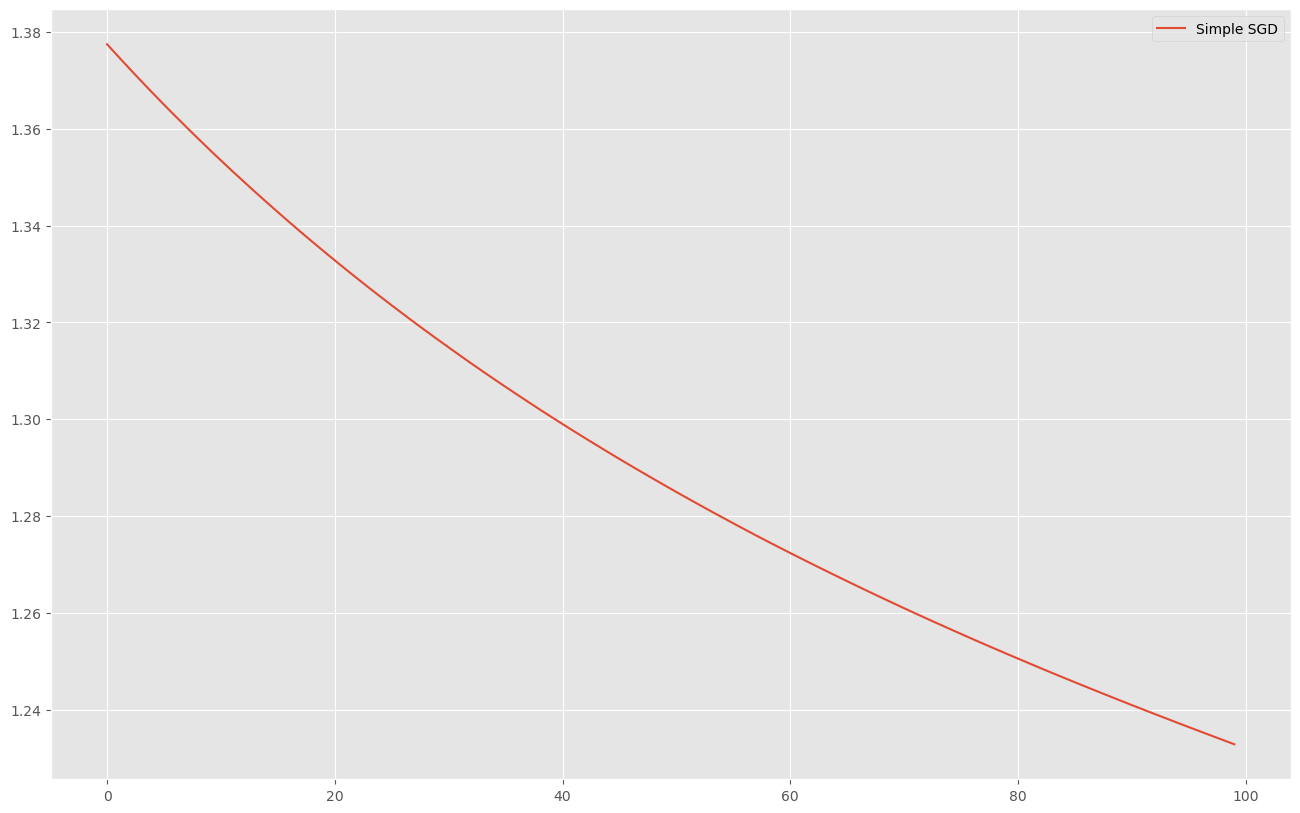

In [17]:
plot([('Simple SGD', valid_loss_values)])

### Nesterov Momentum

In [18]:
# Первая простенькая моделька 
model2 = MyModel()

# инициализируем SGD optimizer
sgd = optim.SGD(model2.parameters(), lr=LEARNING_RATE, momentum=0.9, nesterov=True)

# запускаем процесс обучения
train_loss_values2, train_accuracy_values2, valid_loss_values2, valid_accuracy2 = run_train(model2, optimizer=sgd, criterion=criterion)

EPOCH 0,  train_loss: 1.458452, valid_accuracy: 0.167823
EPOCH 0, valid_loss: 1.440061, valid_accuracy: 0.172532
EPOCH 20,  train_loss: 1.152210, valid_accuracy: 0.536923
EPOCH 20, valid_loss: 1.149774, valid_accuracy: 0.539874
EPOCH 40,  train_loss: 1.013848, valid_accuracy: 0.592150
EPOCH 40, valid_loss: 1.016646, valid_accuracy: 0.585654
EPOCH 60,  train_loss: 0.952249, valid_accuracy: 0.608468
EPOCH 60, valid_loss: 0.959927, valid_accuracy: 0.601748
EPOCH 80,  train_loss: 0.915344, valid_accuracy: 0.621329
EPOCH 80, valid_loss: 0.926320, valid_accuracy: 0.620010


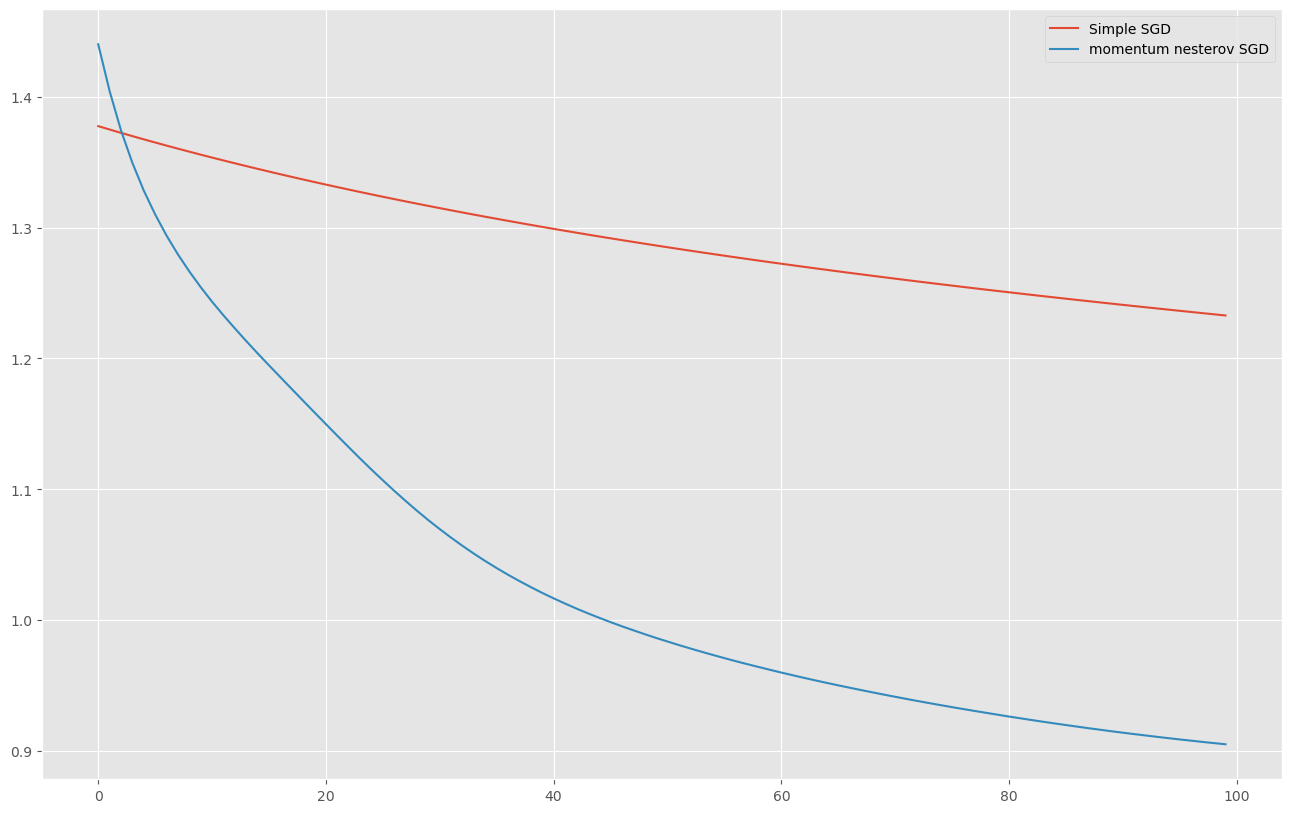

In [19]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2)])


### RMSprop 

In [20]:
# Первая простенькая моделька 
model3 = MyModel()

# инициализируем SGD optimizer
rmsprop = optim.RMSprop(model3.parameters(), lr=LEARNING_RATE, alpha=0.9, eps=1e-08)

# запускаем процесс обучения
train_loss_values3, train_accuracy_values3, valid_loss_values3, valid_accuracy3 = run_train(model3, optimizer=rmsprop, criterion=criterion)

EPOCH 0,  train_loss: 1.245148, valid_accuracy: 0.420895
EPOCH 0, valid_loss: 1.167648, valid_accuracy: 0.496370
EPOCH 20,  train_loss: 0.829782, valid_accuracy: 0.653400
EPOCH 20, valid_loss: 0.856554, valid_accuracy: 0.645343
EPOCH 40,  train_loss: 0.807922, valid_accuracy: 0.662155
EPOCH 40, valid_loss: 0.845537, valid_accuracy: 0.653103
EPOCH 60,  train_loss: 0.793597, valid_accuracy: 0.667529
EPOCH 60, valid_loss: 0.836002, valid_accuracy: 0.653900
EPOCH 80,  train_loss: 0.782455, valid_accuracy: 0.673546
EPOCH 80, valid_loss: 0.827350, valid_accuracy: 0.655697


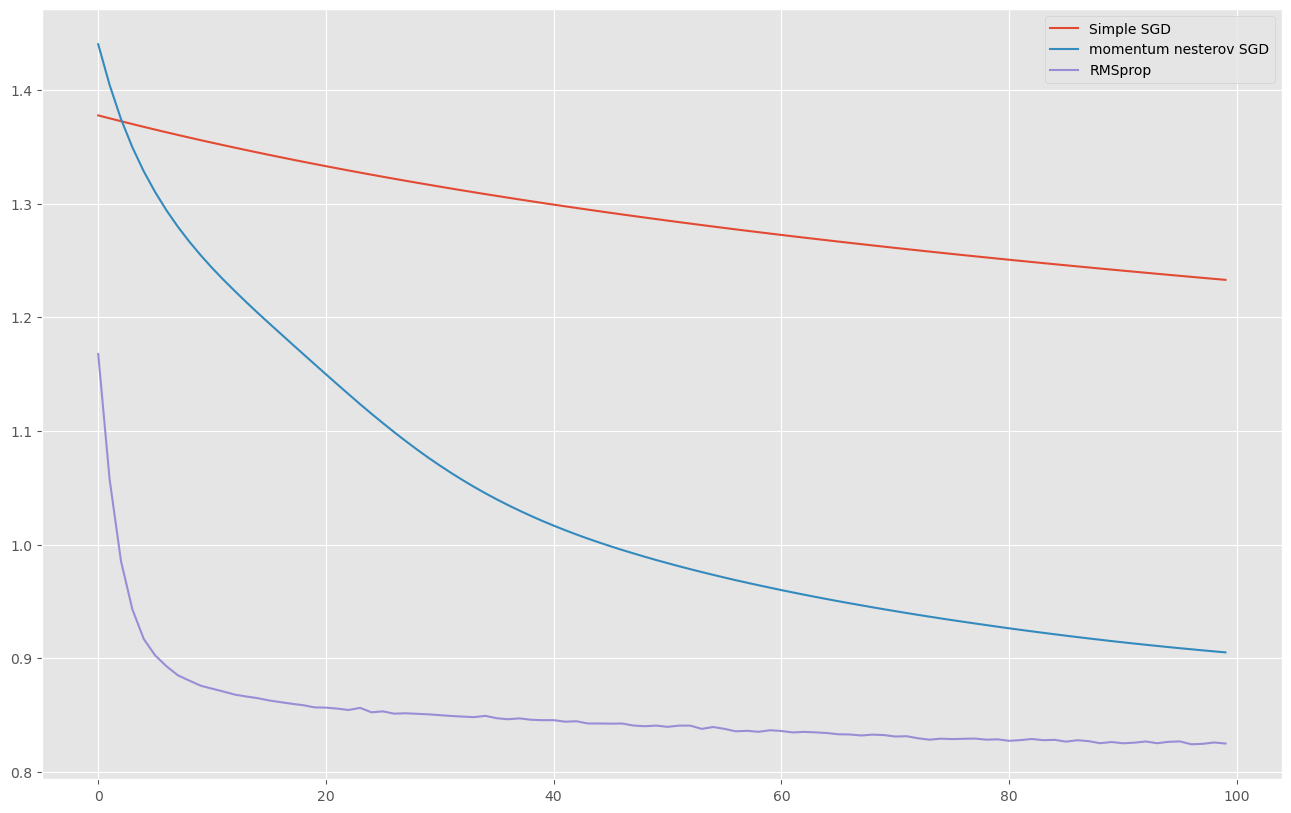

In [21]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2),
      ('RMSprop', valid_loss_values3)])


### Adam 

In [22]:
# Первая простенькая моделька 
model4 = MyModel()

# инициализируем SGD optimizer
adam = optim.Adam(model4.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-08)

# запускаем процесс обучения
train_loss_values4, train_accuracy_values4, valid_loss_values4, valid_accuracy4 = run_train(model4, optimizer=adam, criterion=criterion)

EPOCH 0,  train_loss: 1.282380, valid_accuracy: 0.443706
EPOCH 0, valid_loss: 1.228396, valid_accuracy: 0.529707
EPOCH 20,  train_loss: 0.833515, valid_accuracy: 0.650031
EPOCH 20, valid_loss: 0.856975, valid_accuracy: 0.649715
EPOCH 40,  train_loss: 0.802873, valid_accuracy: 0.662314
EPOCH 40, valid_loss: 0.839696, valid_accuracy: 0.655900
EPOCH 60,  train_loss: 0.780056, valid_accuracy: 0.675400
EPOCH 60, valid_loss: 0.823367, valid_accuracy: 0.661532
EPOCH 80,  train_loss: 0.764479, valid_accuracy: 0.678988
EPOCH 80, valid_loss: 0.815854, valid_accuracy: 0.666050


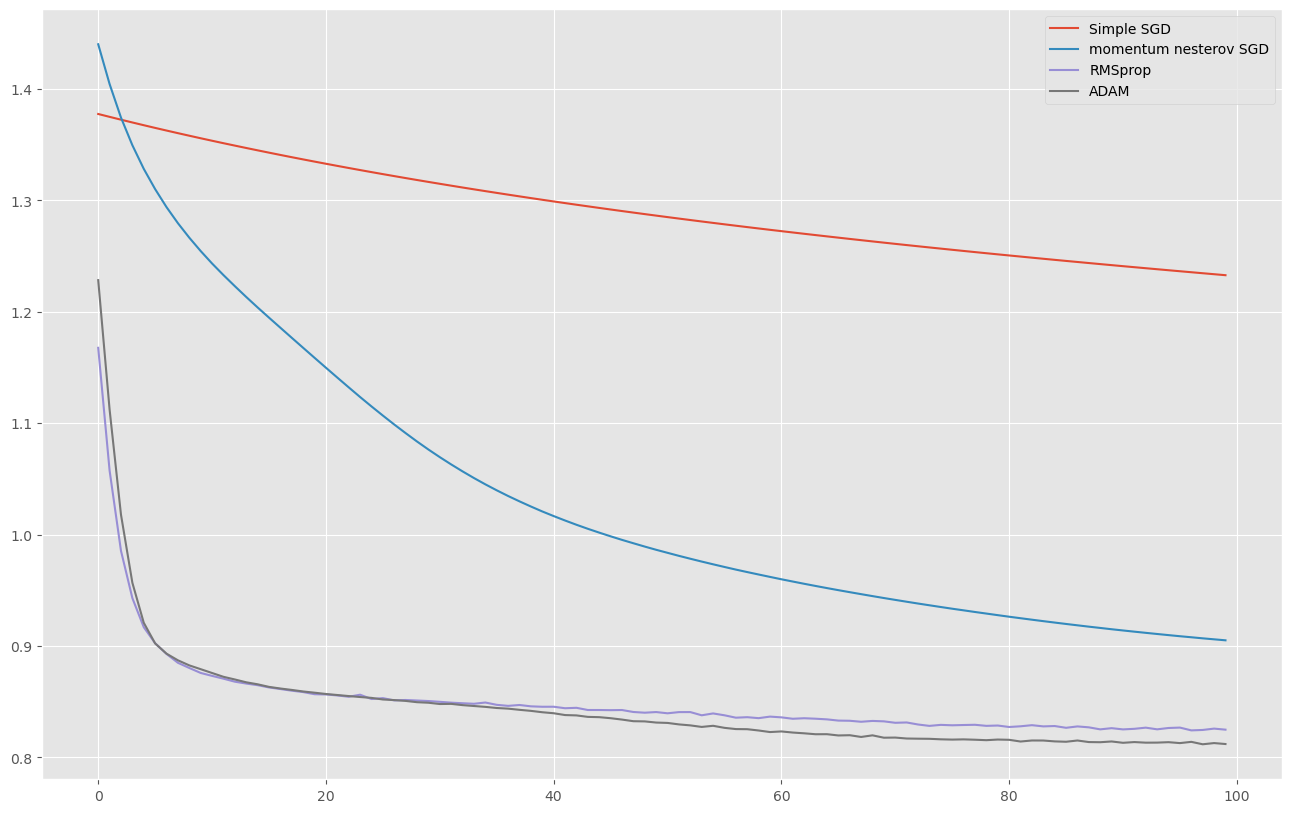

In [23]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2),
      ('RMSprop', valid_loss_values3),
      ('ADAM', valid_loss_values4)])


# 4. Стратегии с постепенным понижением lr 

![](https://raw.githubusercontent.com/FUlyankin/neural_nets_econ/master/2019/sem_2/ahaha.jpg)

In [ ]:
# функция для картинок, чтобы видеть как скорость обученя меняется от эпохи к эпохе
def plot_learning_rate(lr_history):
    fig = plt.figure()
    plt.plot(range(1, EPOCHS+1), lr_history, label='learning rate')
    plt.xlabel("epoch")
    plt.xlim([1, epochs+1])
    plt.ylabel("learning rate")
    plt.legend(loc=0)
    plt.grid(True)
    plt.title("Learning rate")
    plt.show()

Стартовую скорость обучения специально берём большой! 

In [ ]:
INIT_LR = 0.1  # берём lr намеренно большим

In [ ]:
adam = optim.SGD(model5.parameters(), lr=INIT_LR)
scheduler = StepLR(adam, step_size=2, gamma=0.1)

for i in range(10):
    print(i+1, scheduler.get_last_lr())
    scheduler.step()

In [ ]:
len(train_loader)

In [ ]:
from torch.optim.lr_scheduler import StepLR


# Первая простенькая моделька 
model5 = MyModel()

# инициализируем SGD optimizer
adam = optim.Adam(model5.parameters(), lr=INIT_LR, betas=(0.9, 0.999), eps=1e-08)

# инициализируем 
scheduler = StepLR(adam, step_size=50, gamma=0.5)

# запускаем процесс обучения
train_loss_values5, train_accuracy_values5, valid_loss_values5, valid_accuracy5, lr_history5 = run_train(model5, optimizer=adam, 
                                                                                                        criterion=criterion, scheduler=scheduler)

In [ ]:
# Смотрим как скорость обучения по немного понижалась
plot_learning_rate(lr_history5)

In [ ]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2),
      ('RMSprop', valid_loss_values3),
      ('ADAM', valid_loss_values4),
      ('ADAM_step', valid_loss_values5)])

Попробуем ещё вариант!

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR


# Первая простенькая моделька 
model6 = MyModel()

# инициализируем SGD optimizer
adam = optim.Adam(model6.parameters(), lr=INIT_LR, betas=(0.9, 0.999), eps=1e-08)

# инициализируем 
scheduler = MultiStepLR(adam, milestones=[30,80], gamma=0.1)

# запускаем процесс обучения
train_loss_values6, train_accuracy_values6, valid_loss_values6, valid_accuracy6, lr_history6 = run_train(model6, optimizer=adam, 
                                                                                                        criterion=criterion, scheduler=scheduler)

In [ ]:
# Смотрим как скорость обучения по немного понижалась
plot_learning_rate(lr_history6)

In [ ]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2),
      ('RMSprop', valid_loss_values3),
      ('ADAM', valid_loss_values4),
      ('ADAM_step', valid_loss_values5),
      ('ADAM_step 2', valid_loss_values6)])

Существует множество различных Scheduler`ов. Полный список можно найти на [странице](https://pytorch.org/docs/stable/optim.html) в разделе "How to adjust learning rate"

Великолепное описание различных Scheduler`ов и как их применять можно найти по [ссылке](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/)